Starting KNN analysis on Iris dataset...
Optimizing KNN parameters...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Optimization completed in 43.49 seconds
Best parameters: {'algorithm': 'auto', 'n_neighbors': np.int64(17), 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.9793

Model Evaluation:
Accuracy: 0.9667
Precision: 0.9697
Recall: 0.9667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



<Figure size 2000x1500 with 0 Axes>

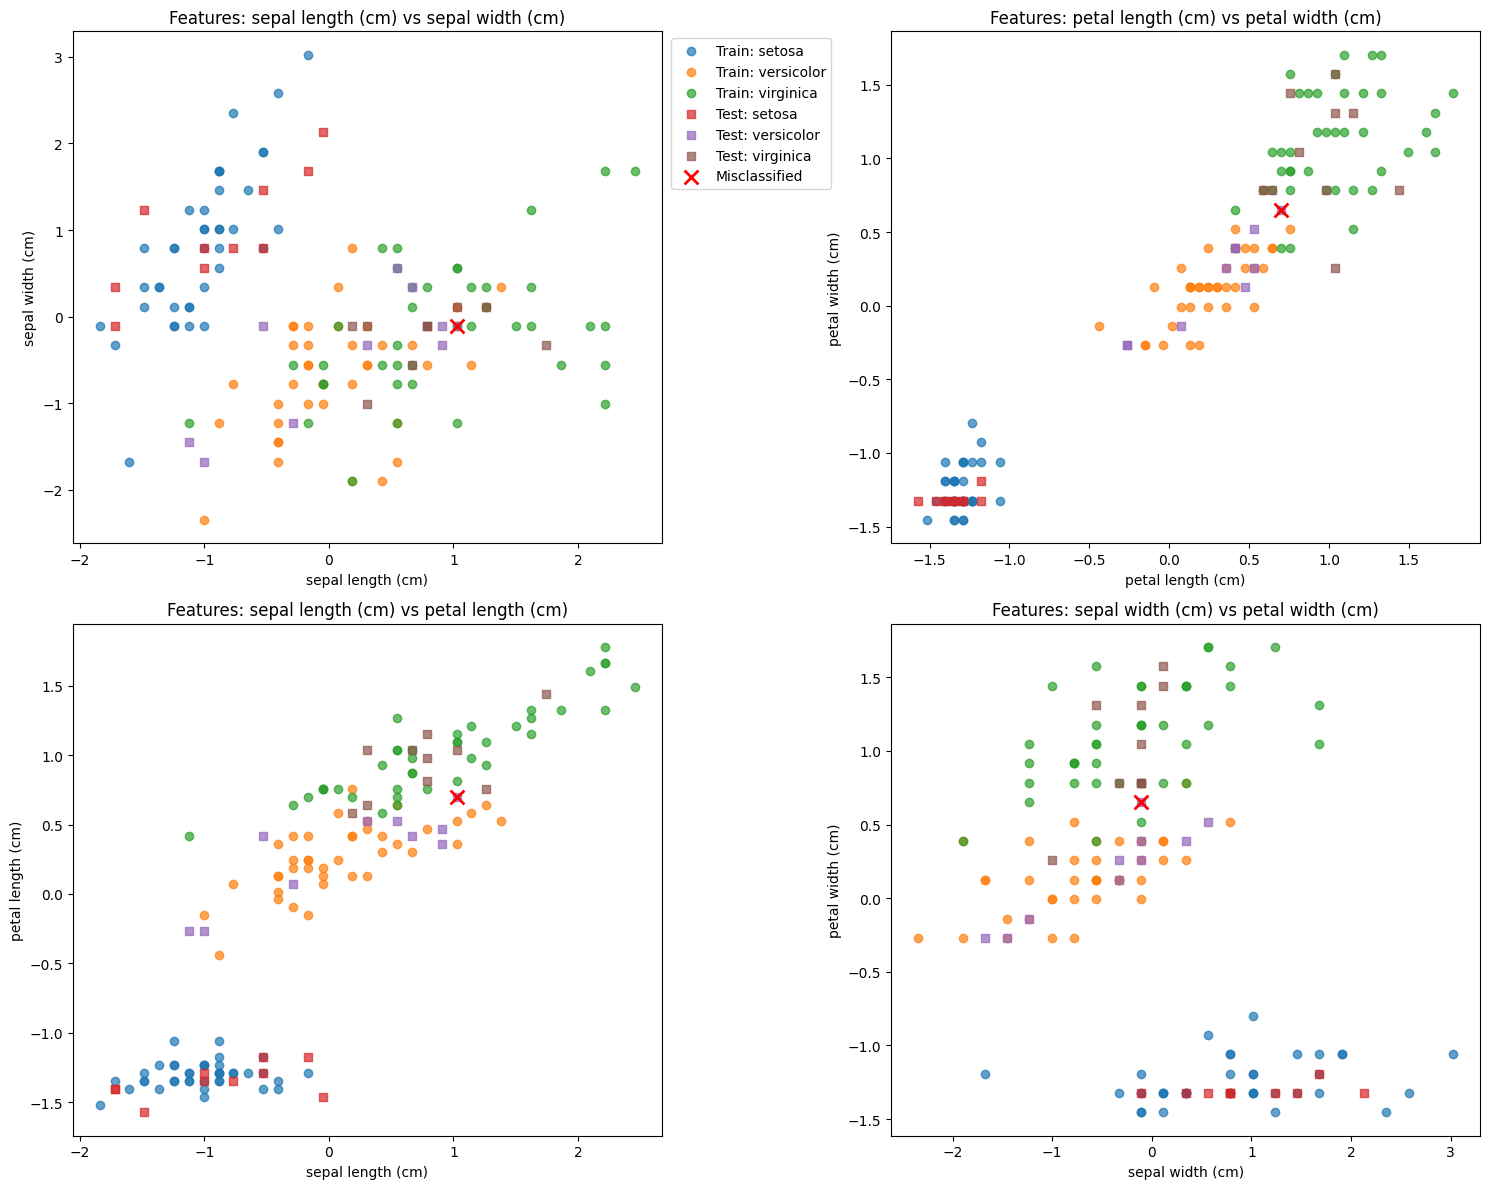

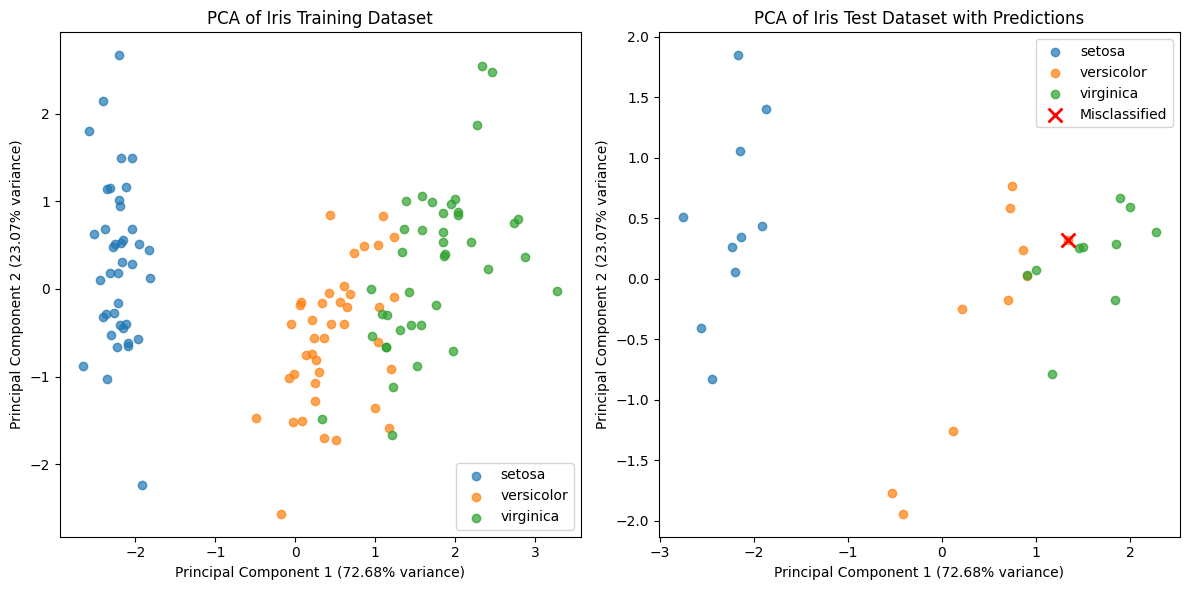

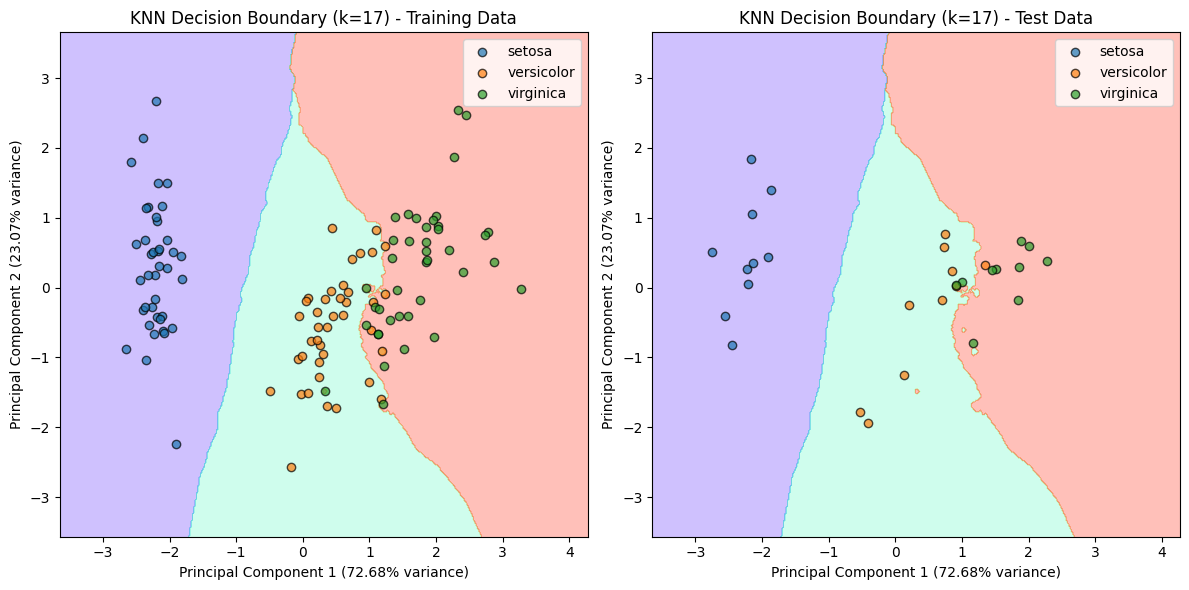

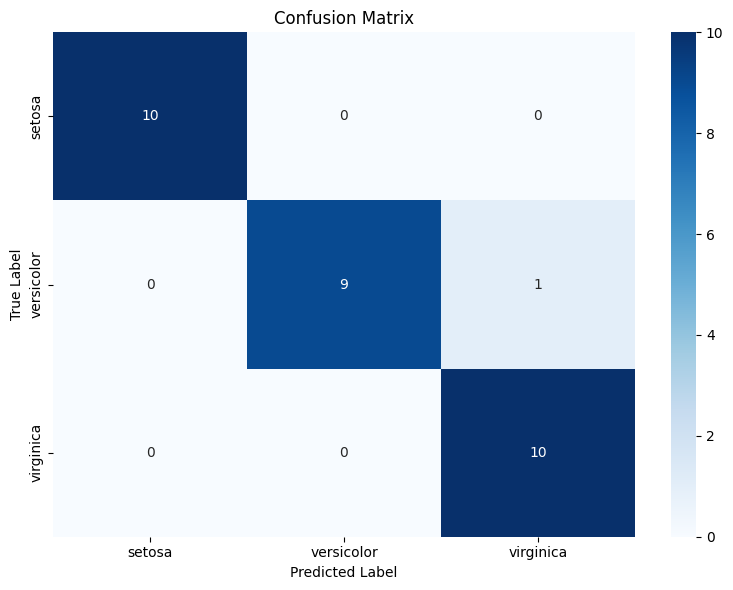

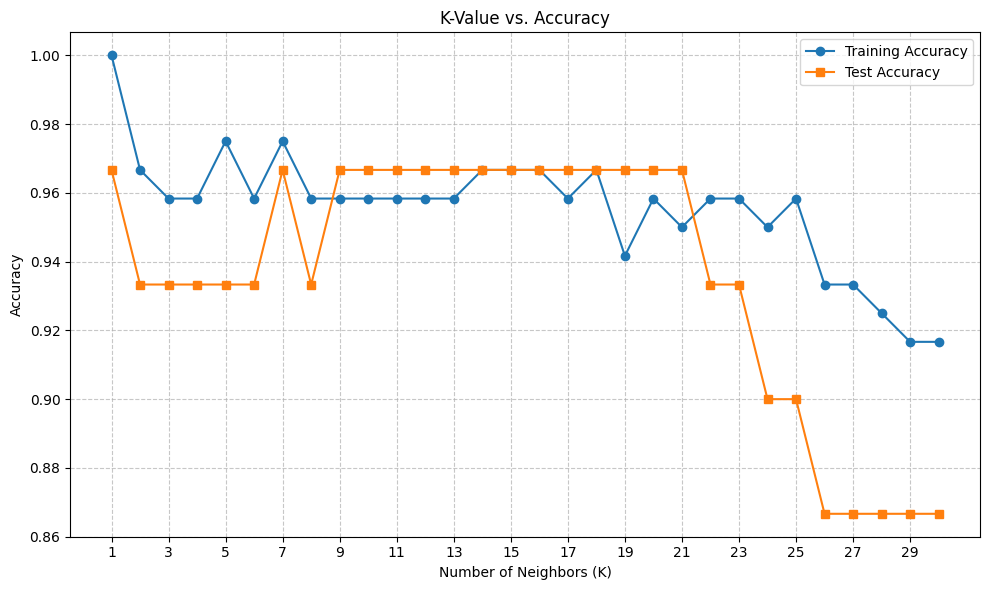

<Figure size 640x480 with 0 Axes>


Analysis complete. Model saved as 'optimal_knn_model.joblib'.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import time
from joblib import dump, load

# Set random seed for reproducibility
np.random.seed(42)

def load_and_prepare_data():
    """Load the Iris dataset and prepare it for modeling"""
    # Load the Iris dataset
    iris = load_iris()
    X = iris.data
    y = iris.target
    feature_names = iris.feature_names
    target_names = iris.target_names

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names, target_names, scaler

def optimize_knn_parameters(X_train, y_train):
    """Find the optimal K value and other hyperparameters using GridSearchCV"""
    # Define the parameter grid
    param_grid = {
        'n_neighbors': np.arange(1, 31),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean
    }

    # Create KNN classifier object
    knn = KNeighborsClassifier(n_jobs=-1)  # Use all available cores

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        knn,
        param_grid,
        cv=5,
        scoring='precision_macro',  # Focus on precision as requested
        n_jobs=-1,  # Use all available cores
        verbose=1
    )

    # Fit the grid search
    print("Optimizing KNN parameters...")
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    # Print results
    print(f"Optimization completed in {end_time - start_time:.2f} seconds")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print performance metrics"""
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    # Print evaluation metrics
    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, cm, y_pred

def visualize_results(X_train, X_test, y_train, y_test, y_pred, feature_names, target_names, model):
    """Create visualizations to help understand the data and model predictions"""
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 15))

    # 1. Pairplot of features with color-coded classes
    plot_feature_pairs(X_train, X_test, y_train, y_test, y_pred, feature_names, target_names)

    # 2. PCA visualization
    plot_pca_visualization(X_train, X_test, y_train, y_test, y_pred, target_names)

    # 3. Decision boundaries (using PCA for 2D visualization)
    plot_decision_boundaries(X_train, X_test, y_train, y_test, model, target_names)

    # 4. Confusion matrix
    plot_confusion_matrix(y_test, y_pred, target_names)

    # 5. K values vs. accuracy
    plot_k_values_accuracy(X_train, y_train, X_test, y_test)

    plt.tight_layout()
    plt.show()

def plot_feature_pairs(X_train, X_test, y_train, y_test, y_pred, feature_names, target_names):
    """Plot pairs of features to visualize the dataset"""
    plt.figure(figsize=(15, 12))

    # Combine training and test data for visualization
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((y_train, y_test))

    # Select the most informative feature pairs
    features_to_plot = [(0, 1), (2, 3), (0, 2), (1, 3)]

    for i, (f1, f2) in enumerate(features_to_plot):
        plt.subplot(2, 2, i+1)

        # Plot training data
        for cls in range(len(target_names)):
            plt.scatter(
                X_train[y_train == cls, f1],
                X_train[y_train == cls, f2],
                marker='o',
                alpha=0.7,
                label=f'Train: {target_names[cls]}'
            )

        # Plot test data
        for cls in range(len(target_names)):
            plt.scatter(
                X_test[y_test == cls, f1],
                X_test[y_test == cls, f2],
                marker='s',
                alpha=0.7,
                label=f'Test: {target_names[cls]}'
            )

        # Highlight misclassifications
        misclassified = X_test[y_test != y_pred]
        mis_true = y_test[y_test != y_pred]
        mis_pred = y_pred[y_test != y_pred]

        if len(misclassified) > 0:
            plt.scatter(
                misclassified[:, f1],
                misclassified[:, f2],
                marker='x',
                s=100,
                linewidths=2,
                color='red',
                label='Misclassified'
            )

        plt.xlabel(feature_names[f1])
        plt.ylabel(feature_names[f2])
        plt.title(f'Features: {feature_names[f1]} vs {feature_names[f2]}')

        if i == 0:  # Only show legend for the first subplot to save space
            plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.savefig('iris_feature_pairs.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_pca_visualization(X_train, X_test, y_train, y_test, y_pred, target_names):
    """Visualize the data using PCA for dimensionality reduction"""
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.subplot(1, 2, 1)
    for i, target in enumerate(target_names):
        plt.scatter(
            X_train_pca[y_train == i, 0],
            X_train_pca[y_train == i, 1],
            alpha=0.7,
            label=target
        )
    plt.title('PCA of Iris Training Dataset')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()

    # Plot test data
    plt.subplot(1, 2, 2)
    for i, target in enumerate(target_names):
        plt.scatter(
            X_test_pca[y_test == i, 0],
            X_test_pca[y_test == i, 1],
            alpha=0.7,
            label=target
        )

    # Highlight misclassifications
    misclassified = np.where(y_test != y_pred)[0]
    if len(misclassified) > 0:
        plt.scatter(
            X_test_pca[misclassified, 0],
            X_test_pca[misclassified, 1],
            marker='x',
            s=100,
            linewidths=2,
            color='red',
            label='Misclassified'
        )

    plt.title('PCA of Iris Test Dataset with Predictions')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('iris_pca.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_decision_boundaries(X_train, X_test, y_train, y_test, model, target_names):
    """Plot decision boundaries of the KNN model using PCA for visualization"""
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Create a new KNN model with the same hyperparameters but trained on PCA data
    knn_pca = KNeighborsClassifier(
        n_neighbors=model.n_neighbors,
        weights=model.weights,
        algorithm=model.algorithm,
        p=model.p
    ).fit(X_train_pca, y_train)

    # Create a mesh grid for visualization
    h = 0.02  # Step size in the mesh
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict class labels for the mesh grid points
    Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 6))

    # Plot decision boundary and training points
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.rainbow)

    # Plot training data
    for i, target in enumerate(target_names):
        plt.scatter(
            X_train_pca[y_train == i, 0],
            X_train_pca[y_train == i, 1],
            alpha=0.7,
            label=target,
            edgecolor='k'
        )

    plt.title(f'KNN Decision Boundary (k={model.n_neighbors}) - Training Data')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()

    # Plot decision boundary and test points
    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.rainbow)

    # Plot test data
    for i, target in enumerate(target_names):
        plt.scatter(
            X_test_pca[y_test == i, 0],
            X_test_pca[y_test == i, 1],
            alpha=0.7,
            label=target,
            edgecolor='k'
        )

    plt.title(f'KNN Decision Boundary (k={model.n_neighbors}) - Test Data')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('iris_decision_boundaries.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_test, y_pred, target_names):
    """Plot confusion matrix to visualize correct and incorrect classifications"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('iris_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_k_values_accuracy(X_train, y_train, X_test, y_test):
    """Plot how different K values affect the model accuracy"""
    k_values = np.arange(1, 31)
    train_accuracy = []
    test_accuracy = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Calculate accuracy on training data
        train_accuracy.append(knn.score(X_train, y_train))

        # Calculate accuracy on test data
        test_accuracy.append(knn.score(X_test, y_test))

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_accuracy, 'o-', label='Training Accuracy')
    plt.plot(k_values, test_accuracy, 's-', label='Test Accuracy')

    plt.title('K-Value vs. Accuracy')
    plt.xlabel('Number of Neighbors (K)')
    plt.ylabel('Accuracy')
    plt.xticks(k_values[::2])  # Show every other k value
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig('iris_k_values_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main function to run the KNN analysis"""
    print("Starting KNN analysis on Iris dataset...")

    # Load and prepare data
    X_train, X_test, y_train, y_test, feature_names, target_names, scaler = load_and_prepare_data()

    # Optimize KNN parameters
    optimal_knn = optimize_knn_parameters(X_train, y_train)

    # Evaluate the model
    accuracy, precision, recall, cm, y_pred = evaluate_model(optimal_knn, X_test, y_test)

    # Visualize the results
    visualize_results(X_train, X_test, y_train, y_test, y_pred, feature_names, target_names, optimal_knn)

    # Save the model for future use
    dump(optimal_knn, 'optimal_knn_model.joblib')
    dump(scaler, 'scaler.joblib')

    print("\nAnalysis complete. Model saved as 'optimal_knn_model.joblib'.")

if __name__ == "__main__":
    main()